In [9]:
azure = False
colab = False

if azure or colab:
    !pip install transformers
    !pip install prettytable
    !pip install tensorflow==2.10
    !pip install plot_keras_history
    !pip install pydot
    !pip install graphviz
    !pip install seqeval

## Library imports

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import csv

import matplotlib.pyplot as plt
%matplotlib inline

from prettytable import PrettyTable

import os
import re
import json
import string
import numpy as np
import pandas as pd
import tensorflow as tf
import transformers
from tensorflow import keras
from keras.utils import plot_model
from tensorflow.keras import layers
from sklearn import preprocessing
from tokenizers import BertWordPieceTokenizer
from transformers import BertTokenizer, TFBertModel, BertConfig

import datetime

from seqeval.metrics import f1_score, classification_report, accuracy_score
from plot_keras_history import plot_history
# from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback
import os
print("tf: " + tf.__version__)
print("transformers: " + transformers.__version__)

2023-05-03 17:03:05.852828: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-03 17:03:12.982619: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-05-03 17:03:21.267244: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-05-03 17:03:21.267366: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

tf: 2.10.0
transformers: 4.16.0


Check if GPU is running

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Data: Import

In [ ]:
# For Google Colab only
if colab:
    !git clone https://github.com/mapriess/GermEval_2014_NER_DEMO.git

In [10]:
pathColab = ''
if colab:
  pathColab = "GermEval_2014_NER_DEMO/"

dataPath_train = pathColab + "Data/NER-de-train.tsv"
dataPath_val = pathColab + "Data/NER-de-dev.tsv"
dataPath_test = pathColab + "Data/NER-de-test.tsv"
dataPath_all = pathColab + "Data/NER-de-all.tsv"

max_len = 50
configuration = BertConfig()

In [5]:
#
# Parser for GermEval 2014 Dataset
#
# Input: Tab-separated file, one token per row, two levels of annotation
# Token    Tag_Level1     Tag_Level2
# 
# Output: Pandas dataframe (columns: Sentence #, Token, TagComb)
#
def parser(path):
    cols = ['Sentence #','Word', 'Tag_Level1', 'Tag_Level2']
    df = pd.read_csv(path, sep='\t', encoding="utf8", quoting=3)

    # Set columns
    cols = ['Sentence #','Word', 'Tag_Level1', 'Tag_Level2']
    df.set_axis(labels=cols, axis='columns', inplace=True)

    # Correct sentence number according to source entries (#)
    # TODO: Find more efficient way to further speed up the parsing
    sent_id = 1
    for index, row in df.iterrows():
        if (row['Sentence #'] == '#'):
            sent_id += 1
            continue
        row['Sentence #'] = "Sentence: " + str(sent_id)

    # Delete rows starting with '#'
    df.drop( df[df['Sentence #'] == '#'].index, inplace=True )

    # Conventional flat named‐entity‐recognition models could be used without any modification once the labels of different levels were joined together into a single level (Agrawal et al. (2022)).
    df['TagComb'] = df['Tag_Level1'] + "+" + df['Tag_Level2']
    df.drop(columns=['Tag_Level1','Tag_Level2'], inplace=True)

    return df

In [16]:
# Data split will be done later since we need to do the label encoding on the whole data set first
df = parser(dataPath_all)

## Data: Preparation

In [17]:
# References
# https://keras.io/examples/nlp/text_extraction_with_bert/
# https://huggingface.co/docs/transformers/glossary

# Get the sentences
def process_csv(df):
    enc_tag = preprocessing.LabelEncoder() # encode the labels
    #all_tags_with_bert_special_tokens_as_tag = list(set(df["TagComb"].tolist() + ["CLS", "SEP", "PAD"])) 
    all_tags_with_bert_special_tokens_as_tag = list(set(df["TagComb"].tolist() + ["PAD"])) 
    enc_tag.fit_transform(all_tags_with_bert_special_tokens_as_tag)
    df["TagCombEncoded"] = enc_tag.transform(df["TagComb"]) # encode the current labels and return them
    print(enc_tag.classes_)
    sentences = df.groupby("Sentence #")["Word"].apply(list).values # list with list of words of the same sentence
    tag = df.groupby("Sentence #")["TagCombEncoded"].apply(list).values # list with list of encoded tags of the same sentence
    return sentences, tag, enc_tag

# Prepare the inputs for feeding into model
def create_inputs_targets(df):
    dataset_dict = {
        "input_ids": [],
        "attention_mask": [],
        "tags": []
    }
    sentences, tags, tag_encoder = process_csv(df)
    
    for sentence, tag in zip(sentences, tags):
        input_ids = []
        target_tags = []
        for idx, word in enumerate(sentence):
            #ids = tokenizer.encode(word, add_special_tokens=False)
            ids = tokenizer.encode(str(word), add_special_tokens=False) # Otherwise "TypeError: TextInputSequence must be str"
            input_ids.extend(ids.ids)
            num_tokens = len(ids)
            target_tags.extend([tag[idx]] * num_tokens)
                    
        # Pad truncate
        input_ids = input_ids[:max_len - 2]
        target_tags = target_tags[:max_len - 2]

        # Add [CLS] and [SEP]
        input_ids = input_ids
        target_tags = target_tags
        
        # Adding attention mask for non-padded input
        attention_mask = [1] * len(input_ids)
        
        # Making all the input embeddings same length by padding
        padding_len = max_len - len(input_ids)
        input_ids = input_ids + ([0] * padding_len)
        attention_mask = attention_mask + ([0] * padding_len)
        target_tags = target_tags + (list(tag_encoder.transform(["PAD"])) * padding_len)
        
        dataset_dict["input_ids"].append(input_ids)
        dataset_dict["attention_mask"].append(attention_mask)
        dataset_dict["tags"].append(target_tags)
        assert len(target_tags) == max_len, f'{len(input_ids)}, {len(target_tags)}'
                
    for key in dataset_dict:
        dataset_dict[key] = np.array(dataset_dict[key])

    # Creating array of input embeddings
    x = [
        dataset_dict["input_ids"],
        dataset_dict["attention_mask"],
    ]
    y = dataset_dict["tags"]
    
    return x, y, tag_encoder


In [18]:
# Create an Array with respective sentences to observe them easier
# = list with list of words of the same sentence
sentences = df.groupby("Sentence #")["Word"].apply(list)

## BERT: Tokenizer

In [25]:
# Reference: https://keras.io/examples/nlp/text_extraction_with_bert/
# Save the slow pretrained tokenizer
slow_tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-uncased") # need to use the multilingual bert
save_path = "./bert-base-multilingual-uncased-tokenizer/"
if not os.path.exists(save_path):
    os.makedirs(save_path)
slow_tokenizer.save_pretrained(save_path)

# Load the fast tokenizer from saved file
tokenizer = BertWordPieceTokenizer("./bert-base-multilingual-uncased-tokenizer/vocab.txt", lowercase=True)

## BERT: Load model

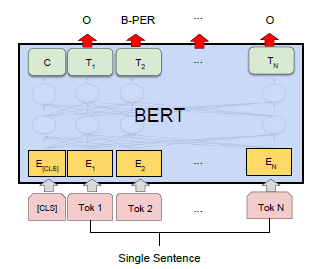

Above image illustrates fine tuning of BERT for NER task.
Source: https://arxiv.org/pdf/1810.04805.pdf

In [84]:
# TEST methods process_csv(df) and create_inputs_targets(df) 
sentencesT, tagsT, tag_encoderT = process_csv(df[:47])
print(sentencesT)
print(tagsT)
print(tag_encoderT.classes_)
print('============')
for sentence, tag in zip(sentencesT, tagsT):
    input_ids = []
    target_tags = []
    print(sentence)
    print(tag)
    print(tag_encoderT.inverse_transform(tag))
    for idx, word in enumerate(sentence):
        print(idx, word)
        ids = tokenizer.encode(str(word), add_special_tokens=False)
        print(ids.tokens, ids.ids, len(ids))
        input_ids.extend(ids.ids)
        num_tokens = len(ids)
        target_tags.extend([tag[idx]] * num_tokens)
        print('============')
    print(input_ids)
    print(target_tags)
    print('============')

['B-LOC+O' 'B-ORG+O' 'B-PER+O' 'I-PER+O' 'O+O' 'PAD']
[list(['Schartau', 'sagte', 'dem', '"', 'Tagesspiegel', '"', 'vom', 'Freitag', ',', 'Fischer', 'sei', '"', 'in', 'einer', 'Weise', 'aufgetreten', ',', 'die', 'alles', 'andere', 'als', 'überzeugend', 'war', '"', '.'])
 list(['Firmengründer', 'Wolf', 'Peter', 'Bree', 'arbeitete', 'Anfang', 'der', 'siebziger', 'Jahre', 'als', 'Möbelvertreter', ',', 'als', 'er', 'einen', 'fliegenden', 'Händler', 'aus', 'dem', 'Libanon', 'traf', '.'])]
[list([2, 4, 4, 4, 1, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])
 list([4, 2, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4])]
['B-LOC+O' 'B-ORG+O' 'B-PER+O' 'I-PER+O' 'O+O' 'PAD']
['Schartau', 'sagte', 'dem', '"', 'Tagesspiegel', '"', 'vom', 'Freitag', ',', 'Fischer', 'sei', '"', 'in', 'einer', 'Weise', 'aufgetreten', ',', 'die', 'alles', 'andere', 'als', 'überzeugend', 'war', '"', '.']
[2, 4, 4, 4, 1, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
['B-PER+O' 'O

In [53]:
x_full, y_full, tag_encoder_full = create_inputs_targets(df)

tag_number_pad = list(tag_encoder_full.transform(["PAD"]))[0]

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction=tf.keras.losses.Reduction.SUM
)

from keras.utils.generic_utils import get_custom_objects

# Ignoring loss that is calculated due to padded targets
def masked_ce_loss(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, tag_number_pad)) # created boolean array to check if a token should be looked after or not
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

def create_model(num_tags):
    # BERT Base model
    encoder = TFBertModel.from_pretrained("bert-base-multilingual-uncased")
    # NER Model
    # Instantiate Keras tensors
    input_ids = layers.Input(shape=(max_len,), dtype=tf.int32)
    attention_mask = layers.Input(shape=(max_len,), dtype=tf.int32)
    # TFBertmodel
    # https://keras.io/examples/nlp/text_extraction_with_bert/
    embedding = encoder.bert(input_ids, attention_mask=attention_mask)[0]
    # Add dropout layer
    embedding = layers.Dropout(0.5)(embedding)
    # Add softmax layer for classifying
    tag_logits = layers.Dense(num_tags+1, activation='softmax')(embedding)
    
    model = keras.Model(
        inputs=[input_ids, attention_mask],
        outputs=[tag_logits],
    )
    optimizer = keras.optimizers.Adam(lr=3e-5)
    model.compile(optimizer=optimizer, loss=masked_ce_loss, metrics=['accuracy'])
    return model


['B-LOC+B-LOC' 'B-LOC+B-LOCderiv' 'B-LOC+B-LOCpart' 'B-LOC+B-ORG'
 'B-LOC+B-PER' 'B-LOC+B-PERderiv' 'B-LOC+O' 'B-LOCderiv+O' 'B-LOCpart+O'
 'B-ORG+B-LOC' 'B-ORG+B-LOCderiv' 'B-ORG+B-LOCpart' 'B-ORG+B-ORG'
 'B-ORG+B-ORGderiv' 'B-ORG+B-ORGpart' 'B-ORG+B-OTH' 'B-ORG+B-OTHderiv'
 'B-ORG+B-PER' 'B-ORG+B-PERderiv' 'B-ORG+B-PERpart' 'B-ORG+O'
 'B-ORGderiv+O' 'B-ORGpart+B-LOC' 'B-ORGpart+B-LOCderiv' 'B-ORGpart+B-ORG'
 'B-ORGpart+B-PER' 'B-ORGpart+O' 'B-OTH+B-LOC' 'B-OTH+B-LOCderiv'
 'B-OTH+B-LOCpart' 'B-OTH+B-ORG' 'B-OTH+B-ORGpart' 'B-OTH+B-OTH'
 'B-OTH+B-OTHpart' 'B-OTH+B-PER' 'B-OTH+B-PERderiv' 'B-OTH+B-PERpart'
 'B-OTH+O' 'B-OTHderiv+O' 'B-OTHpart+B-ORG' 'B-OTHpart+B-OTH'
 'B-OTHpart+O' 'B-PER+B-LOC' 'B-PER+B-ORGpart' 'B-PER+B-PER' 'B-PER+O'
 'B-PERderiv+O' 'B-PERpart+B-PERderiv' 'B-PERpart+O' 'I-LOC+B-LOC'
 'I-LOC+B-LOCderiv' 'I-LOC+B-LOCpart' 'I-LOC+B-PER' 'I-LOC+B-PERderiv'
 'I-LOC+B-PERpart' 'I-LOC+I-LOC' 'I-LOC+I-PER' 'I-LOC+O' 'I-LOCderiv+O'
 'I-LOCpart+O' 'I-ORG+B-LOC' 'I-ORG+B-LOCde

In [54]:
# Reference: https://keras.io/examples/nlp/text_extraction_with_bert/

#num_tags = len(list(set(df["TagComb"].tolist() + ["CLS", "SEP", "PAD"])))
num_tags = len(list(set(df["TagComb"].tolist() + ["PAD"])))
tpu = None
use_tpu = None
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    use_tpu = True
except:
    use_tpu = False

if use_tpu:
    # Create distribution strategy
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)

    # Create model
    with strategy.scope():
        model = create_model(num_tags)
else:
    model = create_model(num_tags)
    
model.summary()

2023-05-03 17:53:51.162221: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-03 17:54:01.822268: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10787 MB memory:  -> device: 0, name: Tesla K80, pci bus id: 0001:00:00.0, compute capability: 3.7
Some layers from the model checkpoint at bert-base-multilingual-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are i

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  167356416   ['input_1[0][0]',                
                                thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 50,                                            

In [60]:
# Somehow does not work on MS Azure
# plot_model(model,'model.png',show_shapes= True)

# BERT: Train Model

In [61]:
print(tag_encoder_full.inverse_transform([16]))
print(tag_encoder_full.inverse_transform([17]))

['B-ORG+B-OTHderiv']
['B-ORG+B-PER']


In [69]:
print(len(x_full), len(x_full[0]), len(x_full[0][0]))

2 31300 50


In [70]:
# Convert Array into Numpy array, since they are nicer to work with 
x_full = np.array(x_full)
y_full = np.array(y_full)

In [73]:
print(x_full.shape)
print(y_full.shape)

(2, 31300, 50)
(31300, 50)


In [90]:
# (Encoded + Decoded) initial input embedding for first sentence
x_full[0][0], tokenizer.decode(x_full[0][0])

(array([16427, 28438, 11521, 69394, 10188,   107, 81381, 65998, 44321,
        10624,   107, 11106, 31208, 27667,   117, 19180, 13741,   107,
        10104, 10673, 33412, 10350, 14993, 35894,   117, 10121, 21785,
        12137, 10233, 10859, 50599, 10163, 10313,   107,   119,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0]),
 'schartau sagte dem " tagesspiegel " vom freitag, fischer sei " in einer weise aufgetreten, die alles andere als uberzeugend war ".')

In [92]:
# Initial attention mask for first sentence (should be filled with 1 and 0)
x_full[1][0]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [88]:
# (Encoded + Decoded) tags for first sentence
y_full[0], tag_encoder_full.inverse_transform(y_full[0])

(array([ 45,  45,  45, 109, 109, 109,  20,  20,  20,  20, 109, 109, 109,
        109, 109,  45, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109,
        109, 109, 109, 109, 109, 109, 109, 109, 109, 110, 110, 110, 110,
        110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110]),
 array(['B-PER+O', 'B-PER+O', 'B-PER+O', 'O+O', 'O+O', 'O+O', 'B-ORG+O',
        'B-ORG+O', 'B-ORG+O', 'B-ORG+O', 'O+O', 'O+O', 'O+O', 'O+O', 'O+O',
        'B-PER+O', 'O+O', 'O+O', 'O+O', 'O+O', 'O+O', 'O+O', 'O+O', 'O+O',
        'O+O', 'O+O', 'O+O', 'O+O', 'O+O', 'O+O', 'O+O', 'O+O', 'O+O',
        'O+O', 'O+O', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD',
        'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD'],
       dtype='<U20'))

In [64]:
x_train, y_train, tag_encoder_tr = x_full[:, :24000, :], y_full[:24000, :], tag_encoder_full
x_val, y_val, tag_encoder_val = x_full[:, 24000:26200, :], y_full[24000:26200, :], tag_encoder_full
x_te, y_te, tag_encoder_te = x_full[:, 26200:, :], y_full[26200:, :], tag_encoder_full

In [65]:
# https://stackoverflow.com/questions/47843265/how-can-i-get-a-keras-models-history-after-loading-it-from-a-file-in-python
# Keras hasn't implemented the possibility of loading the history directly from a loaded model. Instead we have to set it up in advance.
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.backend import clear_session

clear_session()

csv_logger = CSVLogger('training.log', separator=',', append=False)

bs = 64 if use_tpu else 16

history = model.fit(
    [x_train[0], x_train[1]],
    y_train,
    epochs=3,
    verbose=1,
    batch_size=64,
    validation_data=([x_val[0], x_val[1]], y_val),
    callbacks=[csv_logger]
    # validation_split=0.1
)

Epoch 1/3
375/375 [==============================] - 483s 1s/step - loss: 386.9198 - accuracy: 0.9498 - val_loss: 175.4436 - val_accuracy: 0.9756
Epoch 2/3
375/375 [==============================] - 471s 1s/step - loss: 128.6478 - accuracy: 0.9808 - val_loss: 168.3868 - val_accuracy: 0.9777
Epoch 3/3
375/375 [==============================] - 471s 1s/step - loss: 88.9716 - accuracy: 0.9864 - val_loss: 170.2559 - val_accuracy: 0.9785


In [67]:
# save model
#model.save("./saved_model/final-model-perfection")

INFO:tensorflow:Assets written to: ./saved_model/final-model-perfection/assets


INFO:tensorflow:Assets written to: ./saved_model/final-model-perfection/assets


In [66]:
# Load model + history if required
# model = keras.models.load_model("./saved_model/three_epochs_gpu_16bs_multilanguage", custom_objects={"masked_ce_loss": masked_ce_loss}) #works but not enough ram
# log_data = pd.read_csv('training.log', sep=',', engine='python')

In [68]:
training_result = pd.DataFrame(history.history)
training_result.columns

Index(['loss', 'accuracy', 'val_loss', 'val_accuracy'], dtype='object')

(<Figure size 1000x500 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff842da0370>,
       dtype=object))

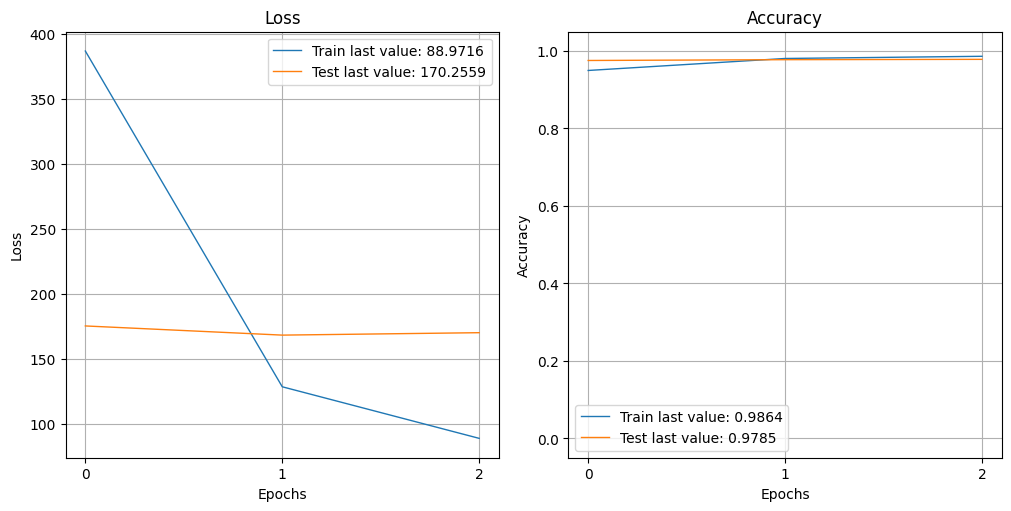

In [69]:
plot_history(history.history)

# BERT: Prediction for test data

In [70]:
y_pred = model.predict([x_te[0], x_te[1]])
y_pred.shape

160/160 [==============================] - 35s 198ms/step


(5100, 50, 112)

In [71]:
# Convert numpy arrays back into python lists, since seqeval can only work with nested lists
y_pred_labels_tag = np.argmax(y_pred, 2)
y_pred_labels = [tag_encoder_full.inverse_transform(sentence).tolist() for sentence in y_pred_labels_tag]
y_te_labels = [tag_encoder_full.inverse_transform(sentence).tolist() for sentence in y_te]

In [78]:
print(classification_report(y_te_labels, y_pred_labels))

                precision    recall  f1-score   support

            AD       1.00      1.00      1.00      5100
     LOC+B-LOC       0.00      0.00      0.00        35
LOC+B-LOCderiv       0.52      0.51      0.51        67
     LOC+B-PER       0.00      0.00      0.00         8
 LOC+B-PERpart       0.00      0.00      0.00         1
     LOC+I-LOC       0.00      0.00      0.00         3
     LOC+I-PER       0.00      0.00      0.00         1
         LOC+O       0.88      0.88      0.88      3227
    LOCderiv+O       0.91      0.83      0.87      1149
     LOCpart+O       0.89      0.67      0.77       464
     ORG+B-LOC       0.65      0.74      0.69       148
ORG+B-LOCderiv       0.50      0.85      0.63       131
 ORG+B-LOCpart       0.00      0.00      0.00         4
     ORG+B-ORG       0.00      0.00      0.00        35
ORG+B-ORGderiv       0.00      0.00      0.00         3
 ORG+B-ORGpart       0.00      0.00      0.00         5
     ORG+B-OTH       0.00      0.00      0.00  

In [72]:
print("f1_score: " + f1_score(y_te_labels, y_pred_labels).astype(str))

f1_score: 0.8543655913978495


In [73]:
print("accuracy: " + str(accuracy_score(y_te_labels, y_pred_labels)))

accuracy: 0.9837137254901961


# BERT: Prediction on existing data sample

In [74]:
# Get Tokens of Bert and compare the tags
tokenizer.encode("Schartau", add_special_tokens=False).tokens

['sc', '##hart', '##au']

In [75]:
# Define data sample to predict
i = 0

y_act = y_train[i]
sent = sentences[i]

tokens = []
for word in sent:
    tokens.extend(tokenizer.encode(word, add_special_tokens=False).tokens)
sentLen = len(tokens)

# Make prediction
y_pred = model.predict([x_train[0][i:i+1] , x_train[1][i:i+1] ])
y_pred = np.argmax(y_pred, 2)

# Inverse transform: encoded tags => real name tags
# Ignore paddings 
y_pred = [tag_encoder_full.inverse_transform(label).tolist() for label in y_pred][0][:sentLen]
y_act = [tag_encoder_full.inverse_transform(label).tolist() for label in y_act.reshape(1,-1)][0][:sentLen]

# print(sent)
# print(y_pred)
# print(y_act)

x = PrettyTable()
x.field_names = ["Word", "Actual Tag", "Predicted Tag"]

for token, act, pred in zip(tokens, y_act, y_pred):
        x.add_row([token, act, pred])
        
print(x)

1/1 [==============================] - 0s 56ms/step
+----------+------------+---------------+
|   Word   | Actual Tag | Predicted Tag |
+----------+------------+---------------+
|    sc    |  B-PER+O   |    B-PER+O    |
|  ##hart  |  B-PER+O   |    B-PER+O    |
|   ##au   |  B-PER+O   |    B-PER+O    |
|  sagte   |    O+O     |      O+O      |
|   dem    |    O+O     |      O+O      |
|    "     |    O+O     |      O+O      |
|  tages   |  B-ORG+O   |    B-ORG+O    |
|   ##sp   |  B-ORG+O   |    B-ORG+O    |
|  ##ieg   |  B-ORG+O   |    B-ORG+O    |
|   ##el   |  B-ORG+O   |    B-ORG+O    |
|    "     |    O+O     |      O+O      |
|   vom    |    O+O     |      O+O      |
|   frei   |    O+O     |      O+O      |
|  ##tag   |    O+O     |      O+O      |
|    ,     |    O+O     |      O+O      |
| fischer  |  B-PER+O   |    B-PER+O    |
|   sei    |    O+O     |      O+O      |
|    "     |    O+O     |      O+O      |
|    in    |    O+O     |      O+O      |
|  einer   |    O+O     

# BERT: Prediction on arbitrary text input

In [76]:
# Prepare test inputs to feed into model
def create_test_input_from_text(test_text):
    dataset_dict = {
        "input_ids": [],
        "token_type_ids": [],
        "attention_mask": []
    }

    input_ids = []
    for idx, word in enumerate(test_text.split()):
        ids = tokenizer.encode(word, add_special_tokens=False)
        #print(ids)
        input_ids.extend(ids.ids)
        num_tokens = len(ids)
                    
    # Pad and create attention masks.
    # Skip if truncation is needed
    input_ids = input_ids[:max_len - 2]

    #input_ids = [101] + input_ids + [102]
    input_ids = input_ids

    n_tokens = len(input_ids)
    attention_mask = [1] * len(input_ids)
    padding_len = max_len - len(input_ids)

    input_ids = input_ids + ([0] * padding_len)
    attention_mask = attention_mask + ([0] * padding_len)
    
    dataset_dict["input_ids"].append(input_ids)
    dataset_dict["attention_mask"].append(attention_mask)
        
    for key in dataset_dict:
        dataset_dict[key] = np.array(dataset_dict[key])

    x = [
        dataset_dict["input_ids"],
        dataset_dict["attention_mask"],
    ]
    return dataset_dict, x, n_tokens

In [84]:
# test input sentence
test_inputs = "Lutz Blochberger hat im Schauspielhaus Zürich ein vom Akademie Theater Bayern München geschriebenes Orchester aufgeführt."
#test_inputs = "Die Deutschen leben in Deutschland."
#test_inputs = "Die Deutschen lieben Bayern München."
#test_inputs = "Italien muss wieder dahin zurückkehren, zuerst seine nationalen Interessen zu verteidigen, sagte Meloni in Mailand."
#test_inputs = "Es war der erste Besuch von Lambrecht in der Ukraine seit Kriegsbeginn."
#test_inputs = "Berlin ist die Hauptstadt von Deutschland und Bayern München ist ein deutscher Fußballclub"
#test_inputs = "Studierende nehmen heute an der Ringvorlesung der Dualen Hochschule Schleswig-Holstein in Kiel teil. Thema der heutigen Veranstaltung ist Named Entity Recognition (NLP)."

dataset, x_test, n_tokens = create_test_input_from_text(test_inputs)

pred_test = model.predict(x_test)
y_pred = np.argmax(pred_test,2)  

# create dictionary of tag and its index
#le_dict = dict(zip(tag_encoder_full.transform(tag_encoder_full.classes_), tag_encoder_full.classes_))
#y_pred = [le_dict.get(_, '[pad]') for _ in y_pred[0][:n_tokens]]

y_pred = [tag_encoder_full.inverse_transform(label).tolist() for label in y_pred][0][:n_tokens]
tokens = tokenizer.encode(test_inputs, add_special_tokens=False).tokens

x = PrettyTable()
x.field_names = ["Word", "Predicted Tag"]

for token, pred in zip(tokens, y_pred):
        x.add_row([token, pred])
        
print(x)

1/1 [==============================] - 0s 54ms/step
+-------------+---------------+
|     Word    | Predicted Tag |
+-------------+---------------+
|     lutz    |    B-PER+O    |
|    bloch    |    I-PER+O    |
|   ##berger  |    I-PER+O    |
|     hat     |      O+O      |
|      im     |      O+O      |
|    schaus   |    B-ORG+O    |
|    ##piel   |    B-ORG+O    |
|    ##haus   |    B-ORG+O    |
|    zurich   |  I-ORG+B-LOC  |
|     ein     |      O+O      |
|     vom     |      O+O      |
|   akademie  |    B-ORG+O    |
|   theater   |    I-ORG+O    |
|    bayern   |  I-ORG+B-LOC  |
|   munchen   |  I-ORG+B-LOC  |
| geschrieben |      O+O      |
|     ##es    |      O+O      |
|  orchester  |      O+O      |
|  aufgefuhrt |      O+O      |
|      .      |      O+O      |
+-------------+---------------+
